### Alternative equation for CPR:
*"Anomalous temperature dependence of the supercurrent through a chaotic Josephson junction"*
$$ I = \frac{e}{\hbar}2k_{B}T\frac{\partial}{\partial \phi}\sum_{n = 0}^{\infty} \ln\left[ \textrm{det}\left(\hat{1} - \hat{s}_{A}(i\omega_{n})\hat{s}_{N}(i\omega_{n}) \right)\right] $$
where $\omega_{n} = (2n + 1)\pi k_{B} T$.

In [1]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

from dataclasses import dataclass
import RGF_single_orbital as so
import RGFtools as rg
@dataclass
class JosephsonParameters:
    W : int # Width of junction in the y direction
    L : int # Length of junction in x-direction.
    a : float
    t: float
    flux : float
    energy: float
    Delta: float
    phase: float
    mu: float
    tol: float
    V_0: float # Tip potential
    d: float # Width of tip potential 
    x_tip: float # x_coordinate of tip
    y_tip: float # y_coordinate of tip
    v :float # Potential barrier at NS interface.
from scipy.linalg import orth

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [81]:
# Computing normal and Andreev reflection matrices between the two superconducting leads:
def compute_normal_s_matrix(params):
    B = params.flux/((params.W)*(params.L ))
    peierlphase = B*params.a*2*np.pi
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a , norbs = 1)

    def tip_potential(V_0 , d ,x , y, x_tip , y_tip):
        return V_0 / ( 1 + ((x - x_tip)**2  + (y - y_tip)**2)/(d**2))
    
    for i in range(int(params.W / params.a)):
        for j in range(int(params.L / params.a)):
            syst[lat(i , j)] = 4*params.t/(params.a**2) - params.mu + tip_potential(params.V_0 , params.d , i*params.a ,
                                                                                    j*params.a , params.x_tip , params.y_tip)
            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -(params.t/(params.a**2))*np.exp(1j*(j*params.a)*peierlphase)/(params.a**2)
            if j > 0:
                syst[lat(i , j) , lat(i , j-1)] = -(params.t/(params.a**2))

    
    # Construct normal leads, with no magnetic field to account for screening.
    lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    for j in range(int(params.L / params.a)):
        lead[lat(0 , j)] = 4*params.t/(params.a**2) - params.mu
        if j > 0:
            lead[lat(0 , j) , lat(0 , j-1)] = -(params.t/(params.a**2))
        lead[lat(1 , j) , lat(0 , j)] = -(params.t/(params.a**2))
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    # Compute S-matrix of the normal region between leads. In the short junction regime , we can calcualte it at E = 0.
    s_matrix = kwant.smatrix(syst , params.energy , check_hermiticity=False)
    wf = kwant.wave_function(syst , energy = params.energy , check_hermiticity=False)
    return s_matrix , wf , syst

def compute_Andreev_reflection_matrix(params):
    # Set-up:
    #-N-N-N-N-N-V-S-S-S-S-
    # Where N= normal metal , S = superconducting lead , V = single slice with an optional potential shift.
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a , norbs = 2) #<- 2 orbitals for electrons and holes.
    
    for i in range(2):
        for j in range(int(params.L/params.a)):
            if i == 0:
                syst[lat(i , j)] =  4*params.t/(params.a**2)*sz - params.mu*sz + params.v*sz
            if i == 1:
                syst[lat(i , j)] =  4*params.t/(params.a**2)*sz - params.mu*sz + params.v*sz + params.Delta*sx                
            if i>0:
                syst[lat(i , j) , lat(i-1 , j)] = -(params.t/(params.a**2))*sz
            if j>0:
                syst[lat(i , j), lat(i , j-1)] = -(params.t/(params.a**2))*sz
    
    normal_lead = kwant.Builder(kwant.TranslationalSymmetry(( -params.a , 0 )) , conservation_law = -sz , particle_hole = sy)
    for j in range(int(params.L / params.a)):
        normal_lead[lat(0 , j)] = 4*params.t/(params.a**2)*sz - params.mu*sz
        if j > 0:
            normal_lead[lat(0 , j), lat(0 , j-1)] =  -(params.t/(params.a**2))*sz
        normal_lead[lat(1 , j) , lat(0 , j)] =  -(params.t/(params.a**2))*sz

    sc_lead = kwant.Builder(kwant.TranslationalSymmetry((-params.a , 0)))
    for j in range(int(params.L / params.a)):
        sc_lead[lat(0 , j)] =  4*params.t/(params.a**2)*sz - params.mu*sz + params.Delta*sx
        if j > 0:
            sc_lead[lat(0 , j), lat(0 , j-1)] =  -(params.t/(params.a**2))*sz
        sc_lead[lat(1 , j) , lat(0 , j)] =  -(params.t/(params.a**2))*sz
    
    syst.attach_lead(normal_lead)
    syst.attach_lead(sc_lead.reversed())
    syst = syst.finalized()

    smatrix = kwant.smatrix(syst , energy = params.energy , check_hermiticity= False)
    return smatrix

(0, 0)
(0, 0)


/var/folders/q7/mt24cx7d41b3712vq5fcskd80000gn/T/ipykernel_3930/4080782282.py:27: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax[0].imshow(np.abs(normal_smatrix.data))
/var/folders/q7/mt24cx7d41b3712vq5fcskd80000gn/T/ipykernel_3930/4080782282.py:27: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax[0].imshow(np.abs(normal_smatrix.data))
/var/folders/q7/mt24cx7d41b3712vq5fcskd80000gn/T/ipykernel_3930/4080782282.py:28: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax[1].imshow(np.abs(ns.data))
/var/folders/q7/mt24cx7d41b3712vq5fcskd80000gn/T/ipykernel_3930/4080782282.py:28: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax[1].imshow(np.abs(ns.data))
/var/folders/q7/mt24

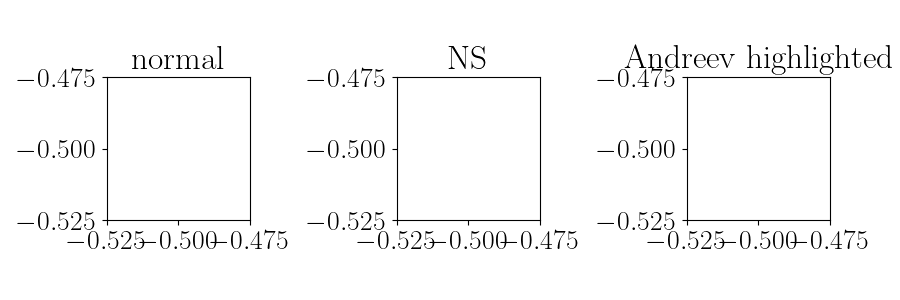

In [87]:
# Parameters:
params = JosephsonParameters(W = 10, # Width of junction in the x direction
                            L = 10 , # Length of junction in y-direction.
                            a = 1 ,
                            t  = 1 ,
                            flux = 0 ,
                            energy = 1j*np.pi*0.01*(2*1 + 1),
                            Delta = 1e-4 ,
                            phase = 0 ,
                            mu = 0.5 ,
                            tol = 0 ,
                            V_0 = 0 ,# Tip potential
                            d= 0.1 , # Width of tip potential 
                            x_tip = 0 ,# x_coordinate of tip
                            y_tip = 0 , # y_coordinate of tip
                            v = 0, # Potential barrier at NS interface.                  
)
# Quick checks:
normal_smatrix , wf , syst = compute_normal_s_matrix(params)
ns = compute_Andreev_reflection_matrix(params)


# Plotting Normal and Andreev reflection matrices:
fig , ax = plt.subplots(nrows = 1 , ncols=3 )
fig.set_figheight(3)
fig.set_figwidth(9)
ax[0].imshow(np.abs(normal_smatrix.data))
ax[1].imshow(np.abs(ns.data))
ax[0].set_title(r'normal')
ax[1].set_title(r'NS')

# Shapes of matrices - do number of propagating modes match up?
print(np.shape(normal_smatrix.data))
print(np.shape(ns.data))

# Marking the Andreev block:
hole_to_electron_slices = ns.block_coords((0 , 0 ) , (0 , 1))
electron_to_hole_slices = ns.block_coords((0 , 1 ) , (0 , 0))
ns_andreev_highlighted = ns.data
ns_andreev_highlighted[hole_to_electron_slices] = 2
ns_andreev_highlighted[electron_to_hole_slices] = 2


ax[2].imshow(np.abs(ns_andreev_highlighted))
# plt.colorbar(mappable = im)
ax[2].set_title('Andreev highlighted')
plt.tight_layout()





In [76]:
print(normal_smatrix.num_propagating(1))
print(ns.num_propagating(0))

2
4


In [ ]:
# # Let's just see if we can get the proper andreev conductance:
# def plot_conductance(energies):
#     # Compute conductance
#     data = np.zeros(shape = energies.shape[0])
#     i = 0
#     for energy in energies:
#         params.energy = energy
#         smatrix = compute_Andreev_reflection_matrix(params)
#         # Conductance is N - R_ee + R_he
#         data[i] = (smatrix.submatrix((0, 0), (0, 0)).shape[0] -
#                     smatrix.transmission((0, 0), (0, 0)) +
#                     smatrix.transmission((0, 1), 0, 0)))
#         i+=1
#     return data

# energies = np.linspace(0 , 0.2 , 101)
# data = plot_conductance(energies)
# plt.figure(figsize = (4 , 4))
# plt.plot(energies , data)